In [1]:
import re
import html
import numpy as np
import pandas as pd
import spacy
from string import punctuation
from math import sqrt, ceil
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm import tqdm
tqdm.pandas()

#### Import custom text preprocessing class for this exercise
For this dataset, the class `Textpreprocessor` is defined in the file `custom_preprocessing.py`.

In [2]:
from custom_preprocessing import TextPreprocessor

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [3]:
data_path = "../data/nytimes.tsv"

df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['date', 'headline', 'content'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [4]:
df1 = df.iloc[:2000, :].copy()
# df1 = df.copy()

#### Include some extra words to remove from article text
Some unnecessary worsd show up in the article text that also need to be added to the default stopword list.

In [5]:
extra_words = ['-pron-', 'mr', 'mrs', 'ms', 'dr', 'million']
removed_words = set(punctuation).union(set(extra_words))

#### Call TextProcessor class
Clean up the text content for the topic model. Stopword removal and lemmatization are done as well. 

In [6]:
preproc = TextPreprocessor()
df1['lemmas'] = df1['content'].progress_apply(
                lambda text: preproc.lemmatize(text, removed_words)
                )
df1.head(3)

100%|██████████| 2000/2000 [00:13<00:00, 148.50it/s]


,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitch, keep, mets, afloat, half, sea..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, de, blasios, counsel, chief, leg..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group..."


#### Obtain contiguous block of lemmas for each document
We need to feed this to the CountVectorizer in scikit-learn

In [7]:
df1['text'] = df1['lemmas'].str.join(sep=' ')
df1.head(3)

,date,headline,content,lemmas,text
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitch, keep, mets, afloat, half, sea...",stellar pitch keep mets afloat half season des...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, de, blasios, counsel, chief, leg...",mayor bill de blasios counsel chief legal advi...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group...",early morning hour labor day year group gunman...


### Vectorize text and return features (tokens) in the model

In [8]:
vectorizer = CountVectorizer(min_df=20, max_df=0.5)
vectorized_data = vectorizer.fit_transform(df1['text'])
features = vectorizer.get_feature_names()

### LDA model in sklearn

In [9]:
def lda_model(num_topics=9, num_iter=200):
    model = LatentDirichletAllocation(
                n_components=num_topics,
                max_iter=num_iter,
                learning_method='online', # expectation maximization
                doc_topic_prior=0.1,      # alpha
                topic_word_prior=None,    # eta = 1/n_components by default
                batch_size=2048,
                n_jobs=-1
            )
    return model

### Show top-n keywords for each topic

In [10]:
def get_topic_keywords(lda_model, features, num_words=15):
    vocab = np.array(features)
    topic_word_weights = []
    
    for i, weights in enumerate(lda_model.components_):
        top_kw_idx = (-weights).argsort()[:num_words]
        words = vocab.take(top_kw_idx)
        topic_word_weights.append(list(zip(words, weights)))
    
    # Get a collection of [topic_number, [(word, weight)]]
    topic_collection = [(i, item) for i, item in enumerate(topic_word_weights)]
        
    return topic_collection

### Wordclouds of most likely words in each topic

In [11]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    # Define the size of the subplot matrix as a function of num_topics  
    subplot_dim = ceil(sqrt(len(topics)))
    fig, axes = plt.subplots(subplot_dim, subplot_dim,
                             figsize=(15, 15), sharex=True, sharey=True);

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        try:
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words)
            plt.gca().imshow(cloud);
            plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16));
            plt.gca().axis('off');
        except IndexError:
            # If there aren't enough topics to fill a square subplot matrix,
            # return a blank plot with no axes
            plt.gca().axis('off');

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.axis('off');
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model

In [12]:
model = lda_model(num_topics=9, num_iter=200)
_ = model.fit_transform(vectorized_data)

In [13]:
# Log likelihood: higher the better
print("Log likelihood: ", model.score(vectorized_data))
# Perplexity = exp(-1 * log-likelihood per word): lower is better
print("Perplexity: ", model.perplexity(vectorized_data))
print(model.get_params())

Log likelihood:  -4396947.380165849
Perplexity:  1755.076766232422
{'batch_size': 2048, 'doc_topic_prior': 0.1, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 200, 'mean_change_tol': 0.001, 'n_components': 9, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Plot wordclouds

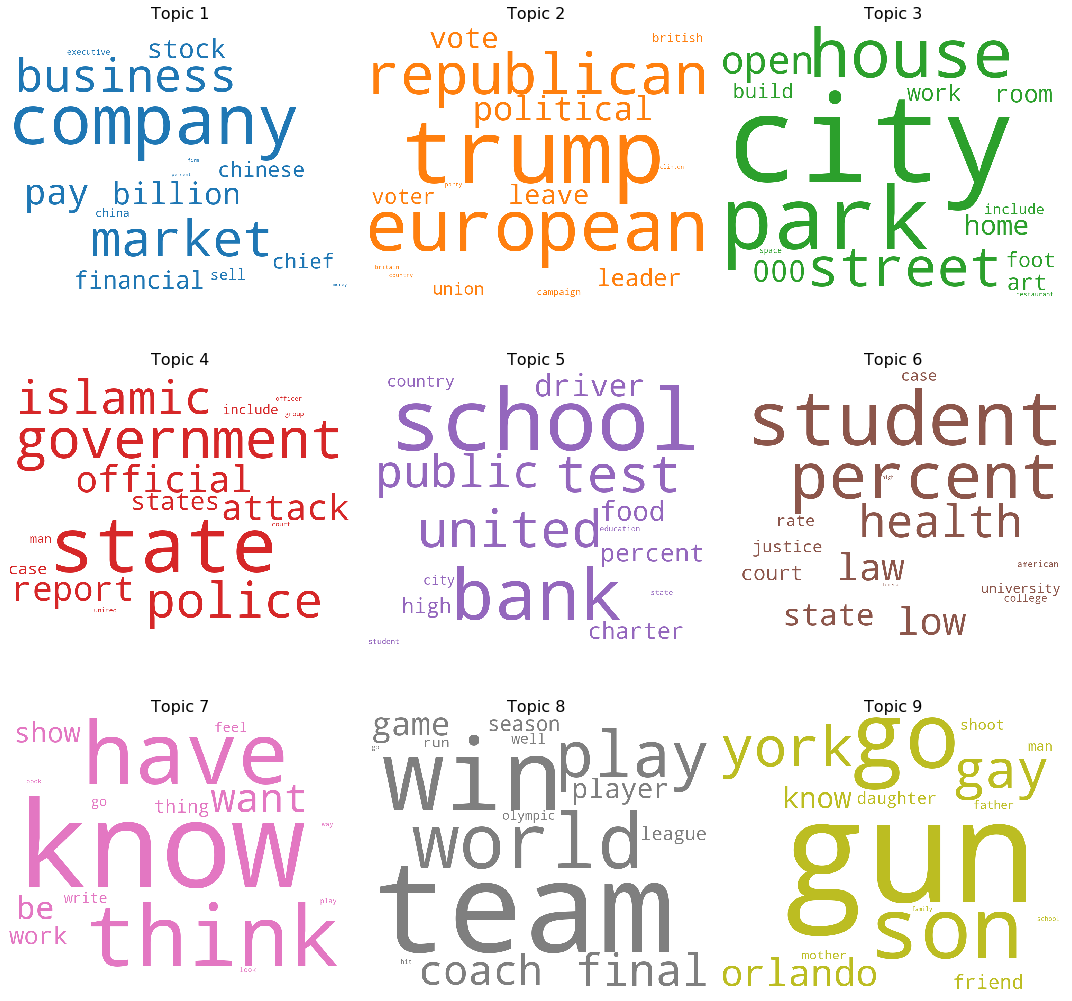

In [14]:
topic_collection = get_topic_keywords(model, features)
plot_wordclouds(topic_collection)